
# Alternative Data Strategy: News Sentiment on DJIA  
## Modular Quant Research Workflow with `backtesting.py`

This notebook implements a simple **alternative data** trading strategy inspired by the ideas in
*Machine Learning for Algorithmic Trading*:

We use:

- **Alternative data**: daily news headlines
- **Sentiment model**: VADER sentiment analysis
- **Asset**: Dow Jones Industrial Average index (**^DJI**)
- **Model**: Logistic Regression on sentiment
- **Backtest engine**: [`backtesting.py`](https://kernc.github.io/backtesting.py/)

### Workflow

1. **Data Curation**
   - Load daily news headlines (Kaggle's `Combined_News_DJIA.csv`).
   - Download daily index data for ^DJI from Yahoo Finance.

2. **Feature Engineering (Sentiment)**
   - Aggregate headlines per day.
   - Compute sentiment scores using VADER.
   - Standardize sentiment into a rolling z-score.

3. **Labeling & Predictive Model**
   - Define next-day direction label (up/down).
   - Train a Logistic Regression model to predict the label from sentiment.

4. **Strategy Construction**
   - Convert model probabilities into long/short/flat signals.

5. **Backtesting & Evaluation**
   - Use `backtesting.py` to simulate trades on ^DJI.
   - Compare performance vs buy & hold.


In [3]:

# !pip install yfinance backtesting vaderSentiment scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import yfinance as yf

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 80)



## 1. Data Curation – News (Alternative Data)

We will use the popular **Daily News for Stock Market Prediction** dataset from Kaggle:

- File: `Combined_News_DJIA.csv`
- Columns:
  - `Date`
  - `Label` (0/1: whether DJIA went up)
  - `Top1` .. `Top25` (top 25 news headlines for that day)

For this strategy, we ignore the provided `Label` and create our own target based on **actual index returns**.

> 🔧 **Setup**: Download `Combined_News_DJIA.csv` from Kaggle and place it in a folder like `./data/`.


In [4]:

news_path = "./data/Combined_News_DJIA.csv"  # <-- adjust this path if needed

news = pd.read_csv(news_path, parse_dates=["Date"])

# Identify headline columns (Top1..Top25)
headline_cols = [c for c in news.columns if c.lower().startswith("top")]

print("Headline columns:", headline_cols[:5], "... total:", len(headline_cols))

news.head()


Headline columns: ['Top1', 'Top2', 'Top3', 'Top4', 'Top5'] ... total: 25


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k


### Aggregate Headlines per Day

We concatenate all the headlines for each day into a single text blob, which will then be passed to the sentiment model.


In [5]:

# Concatenate daily headlines into a single string
news["all_headlines"] = (
    news[headline_cols]
    .fillna("")
    .agg(" ".join, axis=1)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

news = news[["Date", "all_headlines"]].dropna(subset=["all_headlines"])

news.head()


,Date,all_headlines
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,b'Why wont America and Nato help us? If they w...
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,b'All the experts admit that we should legalis...



## 2. Feature Engineering – Sentiment

We use **VADER** to compute a daily sentiment score from the concatenated headlines.

- VADER returns a `compound` score in [-1, 1].
- We then normalize that into a **rolling z-score** to account for regime shifts in the news tone.


In [6]:

analyzer = SentimentIntensityAnalyzer()

def vader_compound(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return analyzer.polarity_scores(text)["compound"]

news["sentiment_raw"] = news["all_headlines"].apply(vader_compound)

# Rolling z-score of sentiment
window = 60  # ~3 months
rolling_mean = news["sentiment_raw"].rolling(window).mean()
rolling_std = news["sentiment_raw"].rolling(window).std()

news["sentiment_z"] = (news["sentiment_raw"] - rolling_mean) / rolling_std
news = news.dropna(subset=["sentiment_z"])

print("News with sentiment:")
news.head()


News with sentiment:


,Date,all_headlines,sentiment_raw,sentiment_z
59,2008-10-31,b'British police ask for camera license!' b'Be...,-0.9938,-0.456223
60,2008-11-03,"b'Every MP to receive a copy of Orwell\'s ""Nin...",-0.9928,-0.394201
61,2008-11-04,b'Kenya declares holiday for Obama' b'The West...,-0.9899,-0.181989
62,2008-11-05,b'London: Smokers to be banned from fostering ...,-0.9827,0.345059
63,2008-11-06,"b'""People \'can\'t wait for ID cards\'"" - WTF?...",-0.9945,-0.475509



## 3. DJIA Price Data & Labeling

We now download daily price data for **^DJI (Dow Jones Industrial Average)** using `yfinance`.

Then we:

- Align the news data with DJIA prices by date.
- Define the **target label** as the sign of the **next-day return**:
  - 1 if next day return > 0
  - 0 otherwise


In [7]:

start_date = news["Date"].min()
end_date = news["Date"].max() + pd.Timedelta(days=5)  # a bit beyond last news date

prices = yf.download("^DJI", start=start_date, end=end_date, auto_adjust=True)
prices = prices[["Open", "High", "Low", "Close", "Volume"]].dropna()

print("Price data:")
print(prices.head())

# Merge news & prices on date
df = news.merge(
    prices,
    left_on="Date",
    right_index=True,
    how="inner",
)

# Next-day return
df["ret_1d"] = df["Close"].pct_change()
df["ret_1d_fwd"] = df["ret_1d"].shift(-1)

# Drop rows where we don't know next-day return or sentiment
df = df.dropna(subset=["ret_1d_fwd", "sentiment_z"])

# Label: 1 if next day up, 0 if down/flat
df["label"] = (df["ret_1d_fwd"] > 0).astype(int)

df = df.set_index("Date").sort_index()

print("Merged data sample:")
df[["sentiment_raw", "sentiment_z", "ret_1d_fwd", "label"]].head()


[*********************100%***********************]  1 of 1 completed


Price data:
Price              Open         High          Low        Close     Volume
Ticker             ^DJI         ^DJI         ^DJI         ^DJI       ^DJI
Date                                                                     
2008-10-31  9179.089844  9454.360352  9119.200195  9325.009766  310950000
2008-11-03  9326.040039  9410.549805  9255.480469  9319.830078  180970000
2008-11-04  9323.889648  9653.950195  9323.889648  9625.280273  254930000
2008-11-05  9616.599609  9616.599609  9111.469727  9139.269531  264640000
2008-11-06  9134.009766  9155.440430  8637.169922  8695.790039  344350000


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [8]:
start_date = news["Date"].min()
end_date = news["Date"].max() + pd.Timedelta(days=5)  # a bit beyond last news date

prices = yf.download("^DJI", start=start_date, end=end_date, auto_adjust=True)

# --- FIX START ---
# Flatten columns if they are MultiIndex (e.g., ('Close', '^DJI') -> 'Close')
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(0)
# --- FIX END ---

prices = prices[["Open", "High", "Low", "Close", "Volume"]].dropna()

print("Price data:")
print(prices.head())

# Merge news & prices on date
df = news.merge(
    prices,
    left_on="Date",
    right_index=True,
    how="inner",
)

# Next-day return
df["ret_1d"] = df["Close"].pct_change()
df["ret_1d_fwd"] = df["ret_1d"].shift(-1)

# Drop rows where we don't know next-day return or sentiment
df = df.dropna(subset=["ret_1d_fwd", "sentiment_z"])

# Label: 1 if next day up, 0 if down/flat
df["label"] = (df["ret_1d_fwd"] > 0).astype(int)

df = df.set_index("Date").sort_index()

print("Merged data sample:")
df[["sentiment_raw", "sentiment_z", "ret_1d_fwd", "label"]].head()

[*********************100%***********************]  1 of 1 completed

Price data:
Price              Open         High          Low        Close     Volume
Date                                                                     
2008-10-31  9179.089844  9454.360352  9119.200195  9325.009766  310950000
2008-11-03  9326.040039  9410.549805  9255.480469  9319.830078  180970000
2008-11-04  9323.889648  9653.950195  9323.889648  9625.280273  254930000
2008-11-05  9616.599609  9616.599609  9111.469727  9139.269531  264640000
2008-11-06  9134.009766  9155.440430  8637.169922  8695.790039  344350000
Merged data sample:


,sentiment_raw,sentiment_z,ret_1d_fwd,label
Date,,,,
2008-10-31,-0.9938,-0.456223,-0.000555,0
2008-11-03,-0.9928,-0.394201,0.032774,1
2008-11-04,-0.9899,-0.181989,-0.050493,0
2008-11-05,-0.9827,0.345059,-0.048525,0
2008-11-06,-0.9945,-0.475509,0.028522,1


In [9]:

print("Label distribution:")
print(df["label"].value_counts())


Label distribution:
label
1    1038
0     891
Name: count, dtype: int64



## 4. Predictive Model – Logistic Regression

We keep the model intentionally simple to focus on the **pipeline**:

- Features:  
  - `sentiment_z` (rolling z-score of VADER sentiment)
- Target:  
  - `label` — 1 if next-day DJIA return > 0, else 0

We split by time into **train** and **test** sets to emulate realistic forward testing.


In [10]:

feature_cols = ["sentiment_z"]

X = df[feature_cols]
y = df["label"]

split_date = "2013-01-01"  # adjust if desired
train = df.loc[:split_date].copy()
test = df.loc[split_date:].copy()

X_train, y_train = train[feature_cols], train["label"]
X_test, y_test = test[feature_cols], test["label"]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

logit = LogisticRegression(
    random_state=RANDOM_STATE,
    solver="lbfgs"
)
logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)

print("=== Classification report (test) ===")
print(classification_report(y_test, y_pred))

print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred))


Train shape: (1048, 1)
Test shape: (881, 1)
=== Classification report (test) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       405
           1       0.54      1.00      0.70       476

    accuracy                           0.54       881
   macro avg       0.27      0.50      0.35       881
weighted avg       0.29      0.54      0.38       881

Confusion matrix (test):
[[  0 405]
 [  0 476]]


c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr


## 5. Strategy Construction – From Probabilities to Signals

Our logistic regression outputs a probability:

\[ p_t = P(\text{next-day return} > 0 \mid \text{sentiment}) \]

We convert this into a **trading signal**:

- If \( p_t > 0.55 \) → go **long** (signal = +1)
- If \( p_t < 0.45 \) → go **short** (signal = −1)
- Else → **flat** (signal = 0)

Orders based on day \( t \)'s signal are executed on the **next bar**, which is how `backtesting.py` behaves by default (no look-ahead).


In [16]:
# Predict probability of "up" on full dataset
proba_up = logit.predict_proba(X)[:, 1]
df["proba_up"] = proba_up

# Use only test period for trading
test["proba_up"] = df.loc[test.index, "proba_up"]

# --- FIX: Relax thresholds to 0.50 ---
threshold_long = 0.50
threshold_short = 0.50

sig = np.zeros(len(test), dtype=int)

# If prob > 0.50, go Long. If < 0.50, go Short.
sig[test["proba_up"] > threshold_long] = 1
sig[test["proba_up"] < threshold_short] = -1

test["signal"] = sig

# DEBUG: Check if we actually have signals now
print("Signal distribution:")
print(pd.Series(sig).value_counts())

test[["sentiment_z", "proba_up", "signal"]].head()

Signal distribution:
1    881
Name: count, dtype: int64


,sentiment_z,proba_up,signal
Date,,,
2013-01-02,-0.377481,0.536760,1
2013-01-03,-0.380757,0.536765,1
2013-01-04,-0.430231,0.536835,1
2013-01-07,0.100892,0.536080,1
2013-01-08,-0.315796,0.536672,1



## 6. Backtesting with `backtesting.py`

We now evaluate the strategy on **^DJI** over the test period.

- Build a DataFrame with OHLCV and `Signal` column for the test window.
- Implement a simple `Strategy` that:
  - Goes long when `Signal` = +1
  - Goes short when `Signal` = −1
  - Closes positions when `Signal` = 0
- Run `Backtest` and inspect statistics and equity curve.


In [17]:

# Build backtesting DataFrame for test period
bt_prices = prices.loc[test.index, ["Open", "High", "Low", "Close", "Volume"]].copy()
bt_prices["Signal"] = test["signal"].reindex(bt_prices.index).fillna(0).astype(int)

bt_prices.head()


Price,Open,High,Low,Close,Volume,Signal
Date,,,,,,
2013-01-02,13104.299805,13412.709961,13104.299805,13412.549805,161430000,1
2013-01-03,13413.009766,13430.599609,13358.299805,13391.360352,129630000,1
2013-01-04,13391.049805,13447.110352,13376.230469,13435.209961,107590000,1
2013-01-07,13436.129883,13436.129883,13343.320312,13384.290039,113120000,1
2013-01-08,13377.419922,13377.419922,13293.129883,13328.849609,129570000,1


In [18]:

class SentimentSignalStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        sig = int(self.data.Signal[-1])
        
        if sig == 1:
            # Want to be long
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif sig == -1:
            # Want to be short
            if not self.position.is_short:
                self.position.close()
                self.sell()
        else:  # sig == 0
            # No position desired
            if self.position:
                self.position.close()


bt = Backtest(
    bt_prices,
    SentimentSignalStrategy,
    cash=100_000,
    commission=0.0005,   # 5 bps per trade
    trade_on_close=False,
    exclusive_orders=True,
)

stats = bt.run()
stats


Backtest.run:   0%|          | 0/880 [00:00<?, ?bar/s]

C:\Users\boleb\AppData\Local\Temp\ipykernel_13336\3997747321.py:33: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


Start                     2013-01-02 00:00:00
End                       2016-06-30 00:00:00
Duration                   1275 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                 131725.71433
Equity Peak [$]                  134402.51707
Return [%]                           31.72571
Buy & Hold Return [%]                 33.6807
Return (Ann.) [%]                     8.20078
Volatility (Ann.) [%]                13.21551
CAGR [%]                              5.59723
Sharpe Ratio                          0.62054
Sortino Ratio                         0.94963
Calmar Ratio                          0.59369
Alpha [%]                            -0.23806
Beta                                  0.94902
Max. Drawdown [%]                   -13.81334
Avg. Drawdown [%]                    -1.53874
Max. Drawdown Duration      408 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                    0
Win Rate [%]                      

In [20]:

print("=== Backtesting stats (test period) ===")
print(stats)

bt.plot()


=== Backtesting stats (test period) ===
Start                     2013-01-02 00:00:00
End                       2016-06-30 00:00:00
Duration                   1275 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                 131725.71433
Equity Peak [$]                  134402.51707
Return [%]                           31.72571
Buy & Hold Return [%]                 33.6807
Return (Ann.) [%]                     8.20078
Volatility (Ann.) [%]                13.21551
CAGR [%]                              5.59723
Sharpe Ratio                          0.62054
Sortino Ratio                         0.94963
Calmar Ratio                          0.59369
Alpha [%]                            -0.23806
Beta                                  0.94902
Max. Drawdown [%]                   -13.81334
Avg. Drawdown [%]                    -1.53874
Max. Drawdown Duration      408 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                

GridPlot(id='p1345', ...)

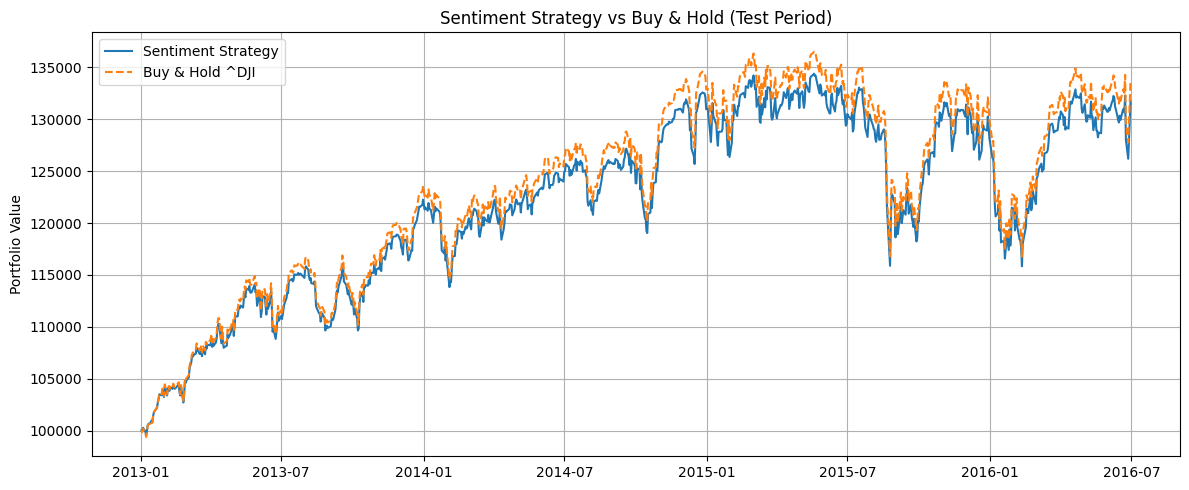

In [19]:
# Compare to buy & hold on the same period
bh_returns = bt_prices["Close"].pct_change().fillna(0)
bh_equity = (1 + bh_returns).cumprod() * 100_000

# --- FIX: Access equity curve correctly ---
strat_equity = stats["_equity_curve"]["Equity"] 

plt.figure(figsize=(12, 5))
plt.plot(strat_equity.index, strat_equity.values, label="Sentiment Strategy")
plt.plot(bh_equity.index, bh_equity.values, label="Buy & Hold ^DJI", linestyle="--")
plt.title("Sentiment Strategy vs Buy & Hold (Test Period)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()



## 7. Recap & Extensions

We implemented an **alternative data** strategy using daily news sentiment on the DJIA:

1. **Data Curation**
   - Loaded daily news headlines (Kaggle `Combined_News_DJIA.csv`).
   - Downloaded daily DJIA price data from Yahoo Finance.

2. **Feature Engineering**
   - Aggregated all daily headlines into a single text string.
   - Computed VADER sentiment scores.
   - Standardized sentiment via a rolling z-score.

3. **Labeling & Predictive Model**
   - Defined target as next-day index direction (up vs down).
   - Trained a Logistic Regression model on sentiment features.

4. **Strategy Construction**
   - Converted model probabilities into long/short/flat signals.

5. **Backtesting**
   - Used `backtesting.py` to simulate trading on ^DJI.
   - Compared strategy performance vs buy & hold on the test period.

---

### Possible Extensions

- Add more **features**:
  - Lags of sentiment (`sentiment_z` at t−1, t−2, ...)
  - Price-based features (momentum, volatility).
- Use more powerful **models**:
  - Random Forest, Gradient Boosting, or Neural Networks (with care).
- Move to a **cross-sectional** setup:
  - Sentiment per stock (or per sector) and trade a portfolio of names.
- Try **different thresholds** or position sizing rules for signals.
- Use a **finance-specific language model** (e.g., FinBERT) instead of VADER for sentiment.

This notebook is designed as a teaching example of how to go from **alternative data → sentiment → ML model → trading strategy → backtest** in a modular way.
